<a href="https://colab.research.google.com/github/a11egra/CGU_SP24/blob/main/project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# import query file query.csv
query = pd.read_csv('query.csv')
query.info()
query

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2060 entries, 0 to 2059
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Enrolled               2060 non-null   int64 
 1   Entry Semester         2060 non-null   object
 2   Citizenship Status     2045 non-null   object
 3   Continent              2058 non-null   object
 4   Country                2058 non-null   object
 5   Program 1 Category     2057 non-null   object
 6   Degree Type            2055 non-null   object
 7   Degree 1               2060 non-null   object
 8   Dual Degree            2060 non-null   int64 
 9   Campus Tour            2060 non-null   int64 
 10  Open House             2060 non-null   int64 
 11  Spring Preview         2060 non-null   int64 
 12  President's Reception  2060 non-null   int64 
 13  Virtual Call           2060 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 225.4+ KB


,Enrolled,Entry Semester,Citizenship Status,Continent,Country,Program 1 Category,Degree Type,Degree 1,Dual Degree,Campus Tour,Open House,Spring Preview,President's Reception,Virtual Call
0,1,Fall 2023,US,North America,United States,Botany,Master's,MS in Botany,1,0,0,0,0,0
1,1,Fall 2023,US,North America,United States,Botany,Master's,MS in Botany,1,0,0,0,0,0
2,1,Fall 2023,US,North America,United States,Botany,PhD,PhD in Botany,1,0,0,1,0,0
3,0,Fall 2023,FN,North America,United States,CISAT,Master's,MS in Information Systems & Technology,1,1,1,0,0,0
4,0,Fall 2023,FN,Asia,India,CISAT,Master's,MS in Information Systems & Technology,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,0,Fall 2023,US,North America,United States,SES,PhD,PhD in Education with SDSU,1,1,1,0,0,1
2056,0,Fall 2023,US,North America,United States,SES,PhD,PhD in Education with SDSU,1,0,0,0,0,0
2057,0,Fall 2023,US,North America,United States,SES,PhD,PhD in Education with SDSU,1,0,0,0,0,1
2058,0,Spring 2023,US,North America,United States,SES,PhD,PhD in Education/Psychology,1,0,0,0,1,1


## Cleaning

In [3]:
# drop any weird rows with null values
full_query = query.dropna(how='any',axis=0)  # drop any rows with null values
full_query.info()
full_query

# split into program-specific dataframes
# qBOT = full_query[full_query['Program 1 Category'] == 'Botany']
qCISAT = full_query[full_query['Program 1 Category'] == 'CISAT']
qDBOS = full_query[full_query['Program 1 Category'] == 'DBOS']
qDPE = full_query[full_query['Program 1 Category'] == 'DPE']
qDSM = full_query[full_query['Program 1 Category'] == 'Drucker']
qIMS = full_query[full_query['Program 1 Category'] == 'IMS']
qSAH = full_query[full_query['Program 1 Category'] == 'SAH']
qSCGH = full_query[full_query['Program 1 Category'] == 'SCGH']
qSES = full_query[full_query['Program 1 Category'] == 'SES']

# drop the program category now that they're split
ROW = 0
COLUMN = 1

def clean_df (df):
  return df.drop(['Program 1 Category', 'Degree 1'], axis=COLUMN)

query_clean = clean_df(full_query)
CISAT_clean = clean_df(qCISAT)
DBOS_clean = clean_df(qDBOS)
DPE_clean = clean_df(qDPE)
DSM_clean = clean_df(qDSM)
IMS_clean = clean_df(qIMS)
SAH_clean = clean_df(qSAH)
SCGH_clean = clean_df(qSCGH)
SES_clean = clean_df(qSES)

<class 'pandas.core.frame.DataFrame'>
Index: 2035 entries, 0 to 2059
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Enrolled               2035 non-null   int64 
 1   Entry Semester         2035 non-null   object
 2   Citizenship Status     2035 non-null   object
 3   Continent              2035 non-null   object
 4   Country                2035 non-null   object
 5   Program 1 Category     2035 non-null   object
 6   Degree Type            2035 non-null   object
 7   Degree 1               2035 non-null   object
 8   Dual Degree            2035 non-null   int64 
 9   Campus Tour            2035 non-null   int64 
 10  Open House             2035 non-null   int64 
 11  Spring Preview         2035 non-null   int64 
 12  President's Reception  2035 non-null   int64 
 13  Virtual Call           2035 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 238.5+ KB


## Indexing

In [4]:
# column index
COLUMNS = query_clean.columns
COL_INDEX = {}
for i, name in enumerate(COLUMNS):
    COL_INDEX[name] = i
print(f"dictionary COL_INDEX is {COL_INDEX}")

# true/false index
TF = ['False','True']
TF_INDEX = {'False':0,'True':1}
for name in TF:
    print(f"{name} maps to {TF_INDEX[name]}")

dictionary COL_INDEX is {'Enrolled': 0, 'Entry Semester': 1, 'Citizenship Status': 2, 'Continent': 3, 'Country': 4, 'Degree Type': 5, 'Dual Degree': 6, 'Campus Tour': 7, 'Open House': 8, 'Spring Preview': 9, "President's Reception": 10, 'Virtual Call': 11}
False maps to 0
True maps to 1


### Mapping

In [5]:
def map_values(df, column_name, mapping):
    if mapping is None:
        unique_values = df[column_name].unique()
        mapping = {value: idx for idx, value in enumerate(unique_values)}
    index_mapping = {idx: value for value, idx in mapping.items()}
    df[column_name] = df[column_name].map(mapping)
    return mapping, index_mapping

# create universal mappings
mappings = {}
for column_name in ['Country', 'Citizenship Status', 'Continent', 'Degree Type', 'Entry Semester']:
		# create universal mappings
    mappings[column_name], _ = map_values(query_clean, column_name, mappings.get(column_name))
    print(mappings[column_name])
		# apply mappings to other dataframes
    CISAT_clean[column_name] = CISAT_clean[column_name].map(mappings[column_name])
    DBOS_clean[column_name] = DBOS_clean[column_name].map(mappings[column_name])
    DPE_clean[column_name] = DPE_clean[column_name].map(mappings[column_name])
    DSM_clean[column_name] = DSM_clean[column_name].map(mappings[column_name])
    IMS_clean[column_name] = IMS_clean[column_name].map(mappings[column_name])
    SAH_clean[column_name] = SAH_clean[column_name].map(mappings[column_name])
    SCGH_clean[column_name] = SCGH_clean[column_name].map(mappings[column_name])
    SES_clean[column_name] = SES_clean[column_name].map(mappings[column_name])

{'United States': 0, 'India': 1, 'Nigeria': 2, 'Ghana': 3, 'The Gambia': 4, 'Kenya': 5, 'Iran': 6, 'China': 7, 'Japan': 8, 'United Kingdom': 9, 'Zimbabwe': 10, 'Uganda': 11, 'Taiwan': 12, 'South Korea': 13, 'Bangladesh': 14, 'Pakistan': 15, 'Jamaica': 16, 'Philippines': 17, 'Saudi Arabia': 18, 'Colombia': 19, 'Eswatini': 20, 'Finland': 21, 'Saint Lucia': 22, 'Kuwait': 23, 'Turkey': 24, 'Hong Kong S.A.R.': 25, 'Romania': 26, 'Germany': 27, 'Burundi': 28, 'Australia': 29, 'United Arab Emirates': 30, 'Austria': 31, 'Russia': 32, 'Liberia': 33, 'Spain': 34, 'Malaysia': 35, 'South Africa': 36, 'Thailand': 37, 'Vietnam': 38, 'Israel': 39, 'Sweden': 40, 'Nepal': 41, 'Canada': 42, 'Italy': 43, 'Congo (Kinshasa)': 44, 'Uzbekistan': 45, 'Rwanda': 46, 'Singapore': 47, 'Jordan': 48, 'Indonesia': 49, 'Ireland': 50, 'Brazil': 51, 'Tanzania': 52, 'Sierra Leone': 53, 'Greece': 54, 'Cambodia': 55, 'Kyrgyzstan': 56, "Cote D'Ivoire": 57, 'Cameroon': 58, 'Sri Lanka': 59, 'Kazakhstan': 60, 'Egypt': 61, 'Et

In [24]:
# add these to reference-able indexes
CITIZENSHIP_INDEX = {v: k for k, v in mappings['Citizenship Status'].items()}
CONTINENT_INDEX = {v: k for k, v in mappings['Continent'].items()}
COUNTRY_INDEX = {v: k for k, v in mappings['Country'].items()}
TYPE_INDEX = {v: k for k, v in mappings['Degree Type'].items()}
SEMESTER_INDEX = {v: k for k, v in mappings['Entry Semester'].items()}

### NumPy

In [7]:
# i'm not going to keep the full query around anymore
CISAT_arr = CISAT_clean.to_numpy()
DBOS_arr = DBOS_clean.to_numpy()
DPE_arr = DPE_clean.to_numpy()
DSM_arr = DSM_clean.to_numpy()
IMS_arr = IMS_clean.to_numpy()
SAH_arr = SAH_clean.to_numpy()
SCGH_arr = SCGH_clean.to_numpy()
SES_arr = SES_clean.to_numpy()

## Data Definitions + Training

In [16]:
def RF_creator(qarray):
  y_all = qarray[:,0]  # y = labels
  X_all = qarray[:,1:15] # X = features

  # scrambling the data using a permuation list
  indices = np.random.permutation(len(y_all))  # indices is a permutation-list
  X_permed = X_all[indices]
  y_permed = y_all[indices]

  X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
  print(f"training with {len(y_train)} rows;  testing with {len(y_test)} rows" )
  return X_all, X_train, X_test, y_all, y_train, y_test

In [17]:
CISAT_X_all, CISAT_X_train, CISAT_X_test, CISAT_y_all, CISAT_y_train, CISAT_y_test = RF_creator(CISAT_arr)
DBOS_X_all, DBOS_X_train, DBOS_X_test, DBOS_y_all, DBOS_y_train, DBOS_y_test = RF_creator(DBOS_arr)
DPE_X_all, DPE_X_train, DPE_X_test, DPE_y_all, DPE_y_train, DPE_y_test = RF_creator(DPE_arr)
DSM_X_all, DSM_X_train, DSM_X_test, DSM_y_all, DSM_y_train, DSM_y_test = RF_creator(DSM_arr)
IMS_X_all, IMS_X_train, IMS_X_test, IMS_y_all, IMS_y_train, IMS_y_test = RF_creator(IMS_arr)
SAH_X_all, SAH_X_train, SAH_X_test, SAH_y_all, SAH_y_train, SAH_y_test = RF_creator(SAH_arr)
SCGH_X_all, SCGH_X_train, SCGH_X_test, SCGH_y_all, SCGH_y_train, SCGH_y_test = RF_creator(SCGH_arr)
SES_X_all, SES_X_train, SES_X_test, SES_y_all, SES_y_train, SES_y_test = RF_creator(SES_arr)

training with 259 rows;  testing with 65 rows
training with 248 rows;  testing with 62 rows
training with 280 rows;  testing with 70 rows
training with 159 rows;  testing with 40 rows
training with 93 rows;  testing with 24 rows
training with 204 rows;  testing with 52 rows
training with 204 rows;  testing with 52 rows
training with 176 rows;  testing with 44 rows


In [10]:
CISAT_list = [CISAT_X_train, CISAT_X_test, CISAT_y_train, CISAT_y_test]
DBOS_list = [DBOS_X_train, DBOS_X_test, DBOS_y_train, DBOS_y_test]
DPE_list = [DPE_X_train, DPE_X_test, DPE_y_train, DPE_y_test]
DSM_list = [DSM_X_train, DSM_X_test, DSM_y_train, DSM_y_test]
IMS_list = [IMS_X_train, IMS_X_test, IMS_y_train, IMS_y_test]
SAH_list = [SAH_X_train, SAH_X_test, SAH_y_train, SAH_y_test]
SCGH_list = [SCGH_X_train, SCGH_X_test, SCGH_y_train, SCGH_y_test]
SES_list = [SES_X_train, SES_X_test, SES_y_train, SES_y_test]

## Random Forest Modeling

### First Model

In [11]:
best_d = 1            # a guess
best_num_trees = 42   # a guess
rforest_model = ensemble.RandomForestClassifier(max_depth=best_d,
                                                n_estimators=best_num_trees,
                                                max_samples=0.5)

def RF_training(df_list):
  rforest_model.fit(df_list[0], df_list[1])
  print(f"Built an RF with depth={best_d} and number of trees={best_num_trees}")
  return rforest_model

CISAT_rforest_model = RF_training([CISAT_X_train, CISAT_y_train])
DBOS_rforest_model = RF_training([DBOS_X_train, DBOS_y_train])
DPE_rforest_model = RF_training([DPE_X_train, DPE_y_train])
DSM_rforest_model = RF_training([DSM_X_train, DSM_y_train])
IMS_rforest_model = RF_training([IMS_X_train, IMS_y_train])
SAH_rforest_model = RF_training([SAH_X_train, SAH_y_train])
SCGH_rforest_model = RF_training([SCGH_X_train, SCGH_y_train])
SES_rforest_model = RF_training([SES_X_train, SES_y_train])

Built an RF with depth=1 and number of trees=42
Built an RF with depth=1 and number of trees=42
Built an RF with depth=1 and number of trees=42
Built an RF with depth=1 and number of trees=42
Built an RF with depth=1 and number of trees=42
Built an RF with depth=1 and number of trees=42
Built an RF with depth=1 and number of trees=42
Built an RF with depth=1 and number of trees=42


### Cross-Validation

In [12]:
DIVISIONS = ['CISAT','DBOS','DPE','DSM','IMS','SAH','SCGH','SES']

def RF_cross_validation(div, rforest_model, X_train, y_train, dep, tree):
  best_d = 1
  best_ntrees = 1
  best_accuracy = 0

  kf = KFold(n_splits=5, shuffle=True)
  for d in dep:
      for ntrees in tree:
          accuracy_sum = 0
          for train_index, test_index in kf.split(X_train, y_train):
              X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
              y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

              rforest_model = ensemble.RandomForestClassifier(
                  max_depth=d,
                  n_estimators=ntrees,
                  max_samples=0.5
              )
              rforest_model.fit(X_train_fold, y_train_fold)
              y_pred = rforest_model.predict(X_test_fold)
              accuracy_sum += accuracy_score(y_test_fold, y_pred)

          average_cv_accuracy = accuracy_sum / kf.get_n_splits()
          # print(f"depth: {d:2d} ntrees: {ntrees:3d} cv accuracy: {average_cv_accuracy:7.4f}")
          if average_cv_accuracy > best_accuracy:
              best_accuracy = average_cv_accuracy
              best_d = d
              best_ntrees = ntrees

  print(f"\nFor {DIVISIONS[div]}:")
  print(f"the best depth is {best_d}")
  print(f"the best number of trees is {best_ntrees}")
  print(f"the best accuracy is {best_accuracy}\n\n")
  return best_d, best_ntrees, best_accuracy

In [13]:
depth=range(1,6)
trees=[50,100,150,200,250,300]

In [14]:
CISAT_best_d, CISAT_best_ntrees, CISAT_best_accuracy = RF_cross_validation(0, CISAT_rforest_model, CISAT_X_train, CISAT_y_train, depth, trees)
DBOS_best_d, DBOS_best_ntrees, DBOS_best_accuracy = RF_cross_validation(1, DBOS_rforest_model, DBOS_X_train, DBOS_y_train, depth, trees)
DPE_best_d, DPE_best_ntrees, DPE_best_accuracy = RF_cross_validation(2, DPE_rforest_model, DPE_X_train, DPE_y_train, depth, trees)
DSM_best_d, DSM_best_ntrees, DSM_best_accuracy = RF_cross_validation(3, DSM_rforest_model, DSM_X_train, DSM_y_train, depth, trees)
IMS_best_d, IMS_best_ntrees, IMS_best_accuracy = RF_cross_validation(4, IMS_rforest_model, IMS_X_train, IMS_y_train, depth, trees)
SAH_best_d, SAH_best_ntrees, SAH_best_accuracy = RF_cross_validation(5, SAH_rforest_model, SAH_X_train, SAH_y_train, depth, trees)
SCGH_best_d, SCGH_best_ntrees, SCGH_best_accuracy = RF_cross_validation(6, SCGH_rforest_model, SCGH_X_train, SCGH_y_train, depth, trees)
SES_best_d, SES_best_ntrees, SES_best_accuracy = RF_cross_validation(7, SES_rforest_model, SES_X_train, SES_y_train, depth, trees)


For CISAT:
the best depth is 5
the best number of trees is 300
the best accuracy is 0.8920060331825038



For DBOS:
the best depth is 5
the best number of trees is 150
the best accuracy is 0.8311020408163265



For DPE:
the best depth is 3
the best number of trees is 300
the best accuracy is 0.9035714285714287



For DSM:
the best depth is 2
the best number of trees is 50
the best accuracy is 0.692741935483871



For IMS:
the best depth is 4
the best number of trees is 200
the best accuracy is 0.8818713450292398



For SAH:
the best depth is 5
the best number of trees is 100
the best accuracy is 0.75



For SCGH:
the best depth is 5
the best number of trees is 50
the best accuracy is 0.8285365853658536



For SES:
the best depth is 3
the best number of trees is 300
the best accuracy is 0.8128571428571428




### Tuned Model

In [19]:
CISAT_model = ensemble.RandomForestClassifier(max_depth=CISAT_best_d,n_estimators=CISAT_best_ntrees,max_samples=0.5)
CISAT_model.fit(CISAT_X_all, CISAT_y_all)
print(f"Built an RF classifier for CISAT with depth={CISAT_best_d} and ntrees={CISAT_best_ntrees}")

DBOS_model = ensemble.RandomForestClassifier(max_depth=DBOS_best_d,n_estimators=DBOS_best_ntrees,max_samples=0.5)
DBOS_model.fit(DBOS_X_all, DBOS_y_all)
print(f"Built an RF classifier for DBOS with depth={DBOS_best_d} and ntrees={DBOS_best_ntrees}")

DPE_model = ensemble.RandomForestClassifier(max_depth=DPE_best_d,n_estimators=DPE_best_ntrees,max_samples=0.5)
DPE_model.fit(DPE_X_all, DPE_y_all)
print(f"Built an RF classifier for DPE with depth={DPE_best_d} and ntrees={DPE_best_ntrees}")

DSM_model = ensemble.RandomForestClassifier(max_depth=DSM_best_d,n_estimators=DSM_best_ntrees,max_samples=0.5)
DSM_model.fit(DSM_X_all, DSM_y_all)
print(f"Built an RF classifier for DSM with depth={DSM_best_d} and ntrees={DSM_best_ntrees}")

IMS_model = ensemble.RandomForestClassifier(max_depth=IMS_best_d,n_estimators=IMS_best_ntrees,max_samples=0.5)
IMS_model.fit(IMS_X_all, IMS_y_all)
print(f"Built an RF classifier for IMS with depth={IMS_best_d} and ntrees={IMS_best_ntrees}")

SAH_model = ensemble.RandomForestClassifier(max_depth=SAH_best_d,n_estimators=SAH_best_ntrees,max_samples=0.5)
SAH_model.fit(SAH_X_all, SAH_y_all)
print(f"Built an RF classifier for SAH with depth={SAH_best_d} and ntrees={SAH_best_ntrees}")

SCGH_model = ensemble.RandomForestClassifier(max_depth=SCGH_best_d,n_estimators=SCGH_best_ntrees,max_samples=0.5)
SCGH_model.fit(SCGH_X_all, SCGH_y_all)
print(f"Built an RF classifier for SCGH with depth={SCGH_best_d} and ntrees={SCGH_best_ntrees}")

SES_model = ensemble.RandomForestClassifier(max_depth=SES_best_d,n_estimators=SES_best_ntrees,max_samples=0.5)
SES_model.fit(SES_X_all, SES_y_all)
print(f"Built an RF classifier for SES with depth={SES_best_d} and ntrees={SES_best_ntrees}")

Built an RF classifier for CISAT with depth=5 and ntrees=300
Built an RF classifier for DBOS with depth=5 and ntrees=150
Built an RF classifier for DPE with depth=3 and ntrees=300
Built an RF classifier for DSM with depth=2 and ntrees=50
Built an RF classifier for IMS with depth=4 and ntrees=200
Built an RF classifier for SAH with depth=5 and ntrees=100
Built an RF classifier for SCGH with depth=5 and ntrees=50
Built an RF classifier for SES with depth=3 and ntrees=300


## Feature Importances

In [20]:
IMP_LIST = [CISAT_model.feature_importances_,
            DBOS_model.feature_importances_,
            DPE_model.feature_importances_,
            DSM_model.feature_importances_,
            IMS_model.feature_importances_,
            SAH_model.feature_importances_,
            SCGH_model.feature_importances_,
            SES_model.feature_importances_]

j = 0
for IMP in IMP_LIST:
    print(f"\nFeature importances for {DIVISIONS[j]}:")
    for i, importance in enumerate(IMP):
        perc = importance * 100
        print(f"  {COLUMNS[i+1]:>21s} has {perc:>5.1f}% of the decision-making importance.")
    j += 1


Feature importances for CISAT:
         Entry Semester has  12.4% of the decision-making importance.
     Citizenship Status has   9.5% of the decision-making importance.
              Continent has  18.9% of the decision-making importance.
                Country has  24.1% of the decision-making importance.
            Degree Type has   6.5% of the decision-making importance.
            Dual Degree has   3.3% of the decision-making importance.
            Campus Tour has   2.9% of the decision-making importance.
             Open House has   0.9% of the decision-making importance.
         Spring Preview has   5.0% of the decision-making importance.
  President's Reception has   6.2% of the decision-making importance.
           Virtual Call has  10.3% of the decision-making importance.

Feature importances for DBOS:
         Entry Semester has   5.4% of the decision-making importance.
     Citizenship Status has  12.5% of the decision-making importance.
              Continent has

In [21]:
DIVISIONS = ['CISAT', 'DBOS', 'DPE', 'DSM', 'IMS', 'SAH', 'SCGH', 'SES']
feature_list = []

for item in DIVISIONS:
  new_var = item + "_features"
  feature_list.append(new_var)

print(feature_list)

['CISAT_features', 'DBOS_features', 'DPE_features', 'DSM_features', 'IMS_features', 'SAH_features', 'SCGH_features', 'SES_features']


In [22]:
j = 0
for IMP in IMP_LIST:
    print(f"\n{feature_list[j]}") # sense check

    new_df = pd.DataFrame(columns=['Feature Index #', 'Feature', 'Importance %']) # create an empty DataFrame

    for i, importance in enumerate(IMP): # construct the new dataframe
        new_df.loc[len(new_df)] = [i+1, COLUMNS[i+1], importance*100]

    new_df.to_csv(f'{DIVISIONS[j]}_features.csv', index=False) # export
    feature_list[j] = new_df # store as a variable
    print(feature_list[j])

    j+=1
    new_df = pd.DataFrame()


CISAT_features
    Feature Index #                Feature  Importance %
0                 1         Entry Semester     12.415767
1                 2     Citizenship Status      9.524502
2                 3              Continent     18.943865
3                 4                Country     24.111115
4                 5            Degree Type      6.548322
5                 6            Dual Degree      3.337963
6                 7            Campus Tour      2.878564
7                 8             Open House      0.858135
8                 9         Spring Preview      4.961185
9                10  President's Reception      6.168654
10               11           Virtual Call     10.251927

DBOS_features
    Feature Index #                Feature  Importance %
0                 1         Entry Semester      5.350390
1                 2     Citizenship Status     12.466014
2                 3              Continent      8.308029
3                 4                Country     12.951838


## Top 3 Counts

### All Admitted Students

In [25]:
# some handy lists to start
clean_list = [CISAT_clean, DBOS_clean, DPE_clean, DSM_clean, IMS_clean, SAH_clean, SCGH_clean, SES_clean]
columns = ['Country', 'Citizenship Status', 'Continent', 'Degree Type', 'Entry Semester']
indexes = [COUNTRY_INDEX, CITIZENSHIP_INDEX, CONTINENT_INDEX, TYPE_INDEX, SEMESTER_INDEX]
DIVISIONS = ['CISAT', 'DBOS', 'DPE', 'DSM', 'IMS', 'SAH', 'SCGH', 'SES']

In [27]:
def find_counts(df, column, index):
    counts = Counter(df[column])

    if len(counts) < 3:
        top = counts.most_common(2)
    else:
        top = counts.most_common(3)

    top_data = {index[item[0]]:item[1] for item in top}
    return top_data

In [28]:
# get this into its own dataframe
def count_df(df,division):
    count_df = pd.DataFrame(columns=['Division', 'Feature', 'Value', 'Count'])
    for column, index in zip(columns, indexes):
        top = find_counts(df, column, index)
        if top:
          for item in top.items():
            count_df.loc[len(count_df)] = [division, column, item[0], item[1]]
    count_df.to_csv(f'{division}_counts_all.csv', index=False) # export
    count_df.info()
    return count_df

In [29]:
# and do it for all the divisions!
for df, division in zip(clean_list,DIVISIONS):
    count_df(df, division)

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 0 to 14
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Division  15 non-null     object
 1   Feature   15 non-null     object
 2   Value     15 non-null     object
 3   Count     15 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 600.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Division  14 non-null     object
 1   Feature   14 non-null     object
 2   Value     14 non-null     object
 3   Count     14 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 560.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 0 to 14
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Division  15 non-null     object
 1   Feature   15 non-null   

### Enrolled Students Only

In [30]:
# new dataframes to only include enrolled students
CISAT_enrolled = CISAT_clean[CISAT_clean['Enrolled'] == 1].copy()
DBOS_enrolled = DBOS_clean[DBOS_clean['Enrolled'] == 1].copy()
DPE_enrolled = DPE_clean[DPE_clean['Enrolled'] == 1].copy()
DSM_enrolled = DSM_clean[DSM_clean['Enrolled'] == 1].copy()
IMS_enrolled = IMS_clean[IMS_clean['Enrolled'] == 1].copy()
SAH_enrolled = SAH_clean[SAH_clean['Enrolled'] == 1].copy()
SCGH_enrolled = SCGH_clean[SCGH_clean['Enrolled'] == 1].copy()
SES_enrolled = SES_clean[SES_clean['Enrolled'] == 1].copy()

In [31]:
enrolled_list = [CISAT_enrolled, DBOS_enrolled, DPE_enrolled, DSM_enrolled, IMS_enrolled, SAH_enrolled, SCGH_enrolled, SES_enrolled]

In [32]:
def count_df2(df, division):
    count_df2 = pd.DataFrame(columns=['Division', 'Feature', 'Value', 'Count'])
    for column, index in zip(columns, indexes):
        top = find_counts(df, column, index)
        if top:
            for item in top.items():
                count_df2.loc[len(count_df2)] = [division, column, item[0], item[1]]
    count_df2.to_csv(f'{division}_counts_enrolled.csv', index=False) # export
    count_df2.info()
    return count_df2

In [33]:
for df, division in zip(enrolled_list, DIVISIONS):
    count_df2(df, division)

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Division  14 non-null     object
 1   Feature   14 non-null     object
 2   Value     14 non-null     object
 3   Count     14 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 560.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Division  12 non-null     object
 1   Feature   12 non-null     object
 2   Value     12 non-null     object
 3   Count     12 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 480.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 0 to 14
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Division  15 non-null     object
 1   Feature   15 non-null   

## Visualizing

### Bar Chart

In [34]:
# I didn't end up analyzing Degree 1 for this visual
for df in feature_list:
    df.drop(df[df['Feature'] == 'Degree 1'].index, inplace=True)

In [36]:
CISAT_features = feature_list[0]
DBOS_features = feature_list[1]
DPE_features = feature_list[2]
DSM_features = feature_list[3]
IMS_features = feature_list[4]
SAH_features = feature_list[5]
SCGH_features = feature_list[6]
SES_features = feature_list[7]

In [37]:
# using CISAT arbitrarily since the feature list index will be the same across dfs
feature_index=CISAT_features['Feature']

In [38]:
CISAT=dict(zip(CISAT_features['Feature'],CISAT_features['Importance %']))
DBOS=dict(zip(DBOS_features['Feature'],DBOS_features['Importance %']))
DPE=dict(zip(DPE_features['Feature'],DPE_features['Importance %']))
DSM=dict(zip(DSM_features['Feature'],DSM_features['Importance %']))
IMS=dict(zip(IMS_features['Feature'],IMS_features['Importance %']))
SAH=dict(zip(SAH_features['Feature'],SAH_features['Importance %']))
SCGH=dict(zip(SCGH_features['Feature'],SCGH_features['Importance %']))
SES=dict(zip(SES_features['Feature'],SES_features['Importance %']))

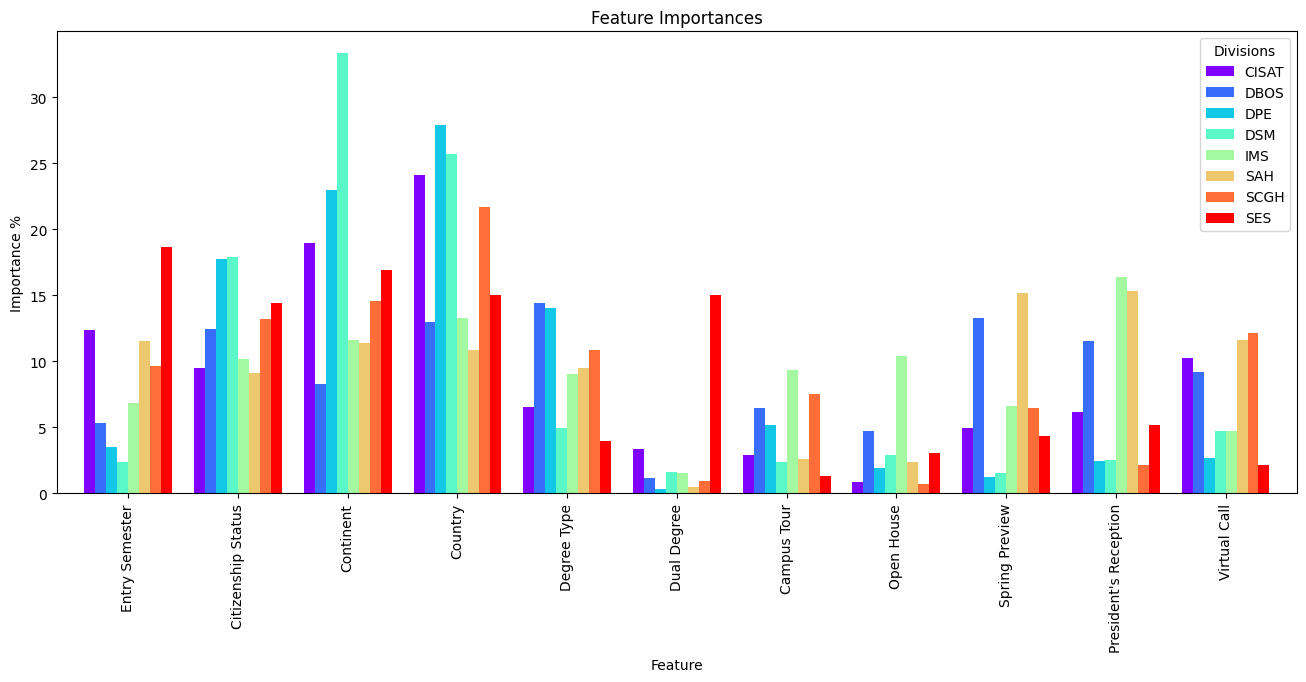

In [45]:
featureplot = pd.DataFrame({'CISAT': CISAT, 'DBOS':DBOS, 'DPE':DPE, 'DSM':DSM,
                      'IMS':IMS, 'SAH':SAH, 'SCGH':SCGH, 'SES':SES}, index=feature_index)

# setting a rainbow color scheme
colordef = plt.cm.rainbow(np.linspace(0, 1, 8))

# create the plot
featureplot.plot.bar(figsize=(16, 6),color=colordef ,width=0.8)

# title, legend, and axes
plt.title("Feature Importances")
plt.legend(title="Divisions")
plt.ylabel("Importance %")

# export and show the plot
plt.savefig('feature_importances.png',bbox_inches='tight')
plt.show()

### Pie Chart

In [40]:
def pie_chart(df, division):
    labels = df['Feature']
    sizes = df['Importance %']

    # Define a custom color palette
    colors = cm.rainbow([x / len(labels) for x in range(len(labels))])

    # plot display
    plt.figure(figsize=(20, 10))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.axis('equal')
    plt.title(f'Feature Importance for {division}', weight='bold', pad=20)
    plt.legend(loc='upper left', bbox_to_anchor=(0.85, 1))

    # exporting and viewing
    plt.savefig(f'{division}_pie_chart.png')
    plt.show()

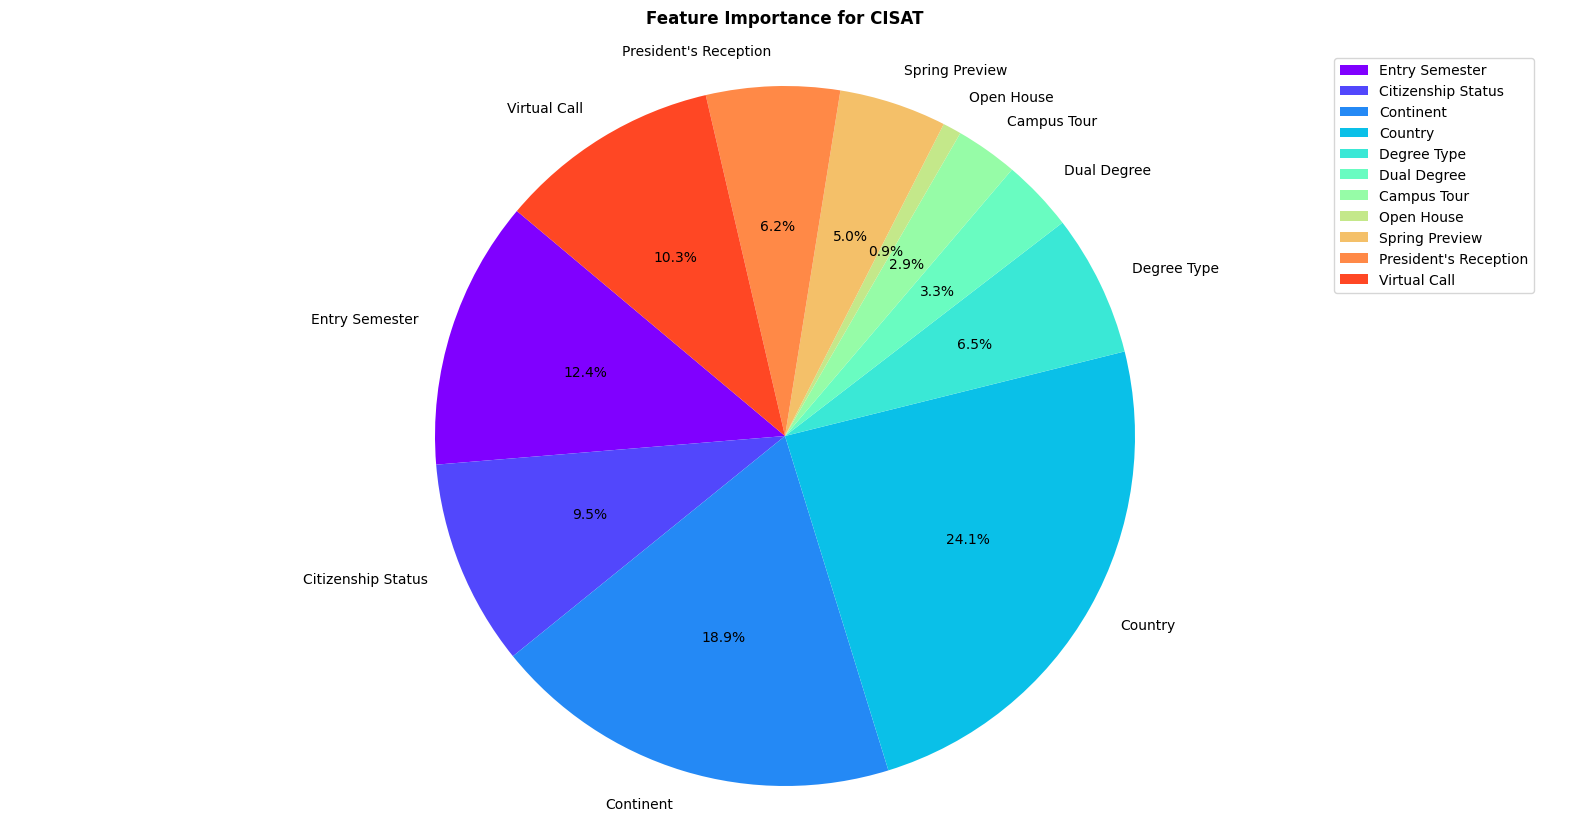

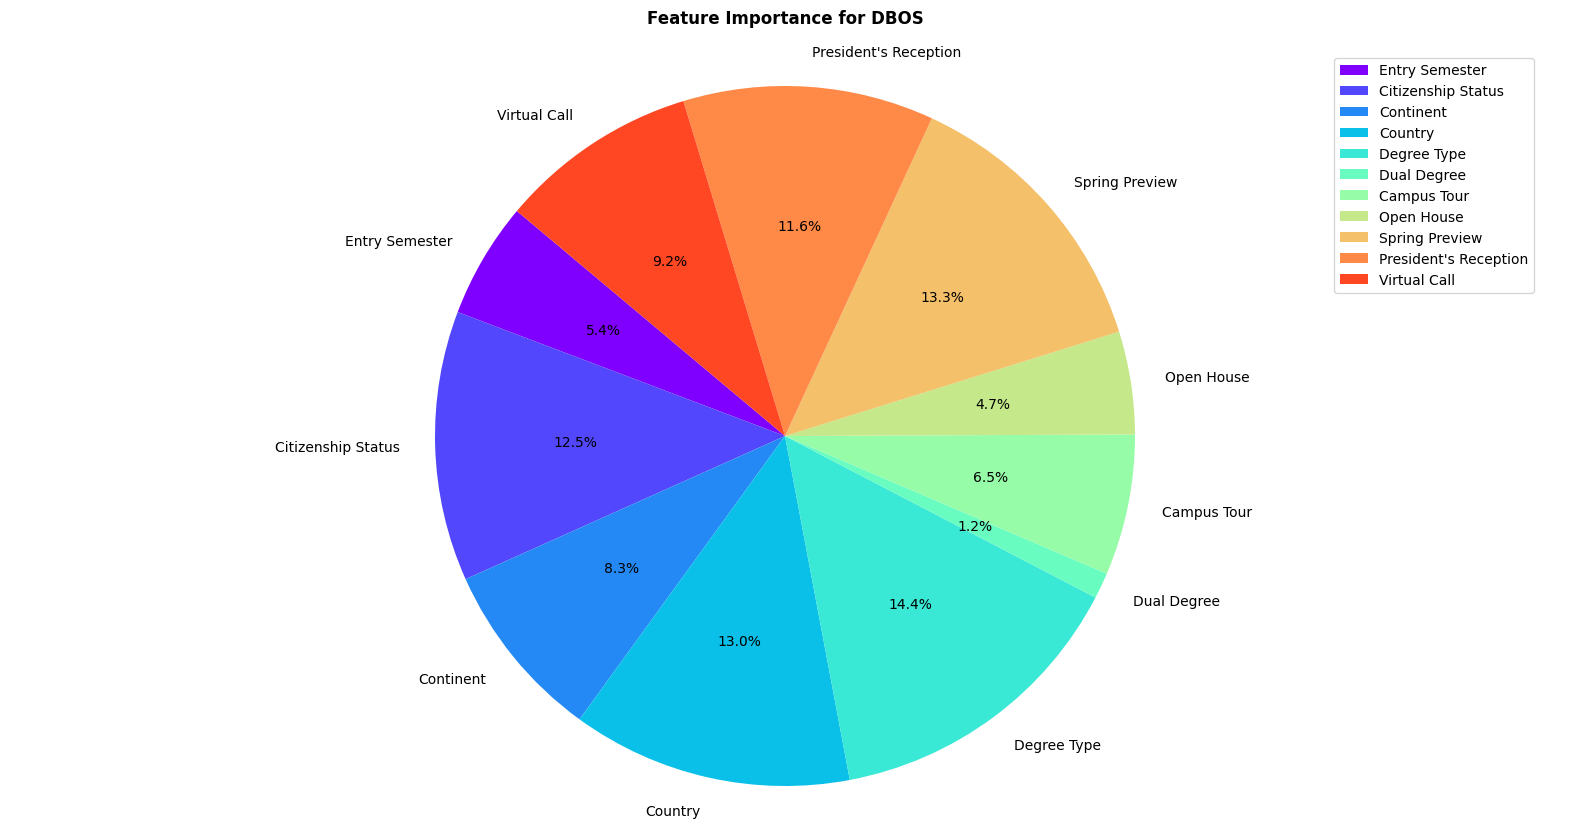

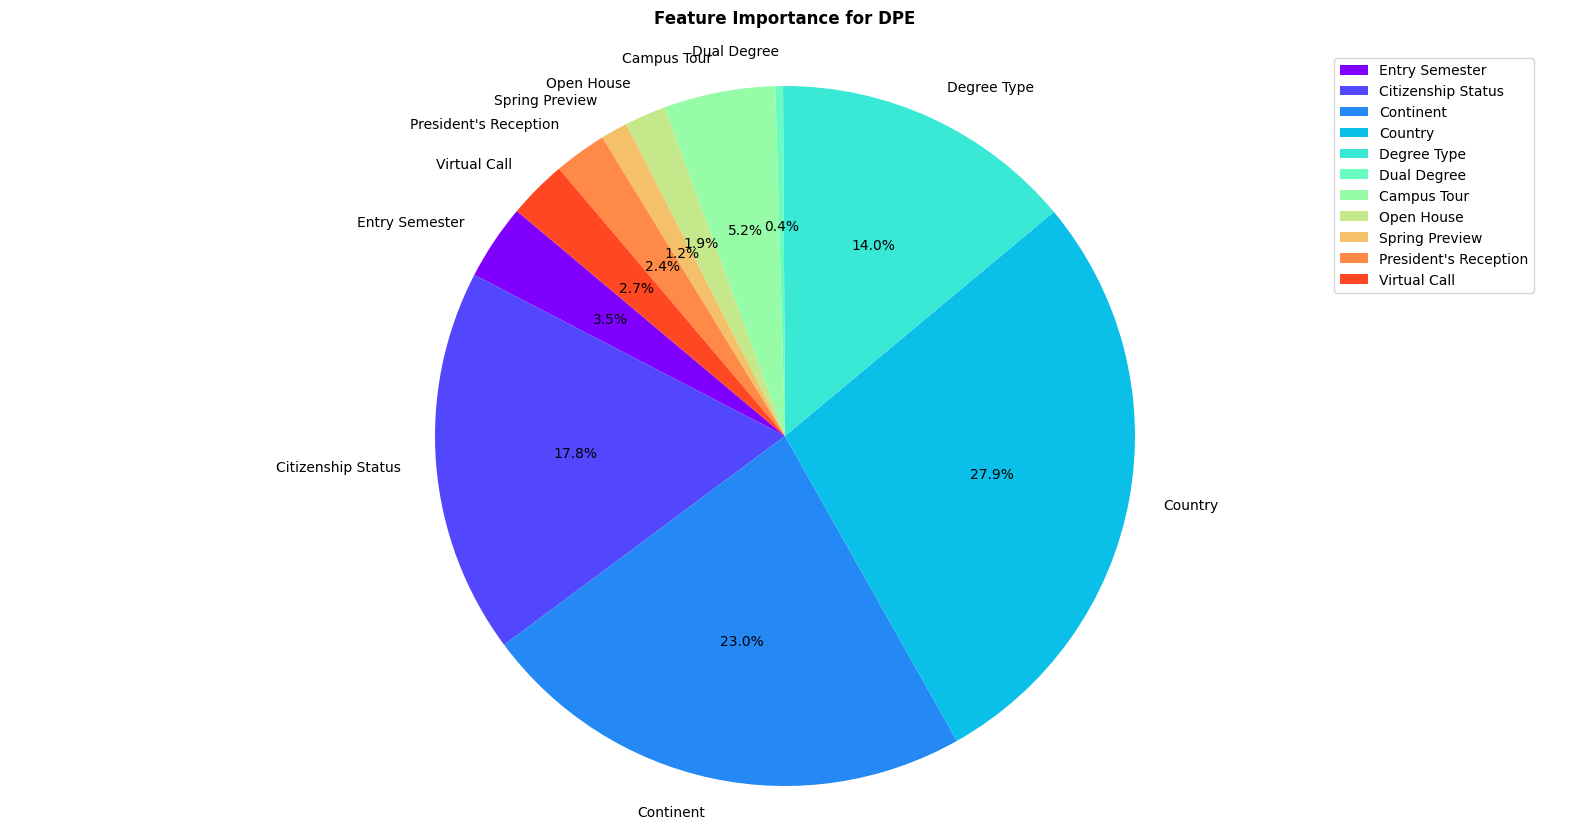

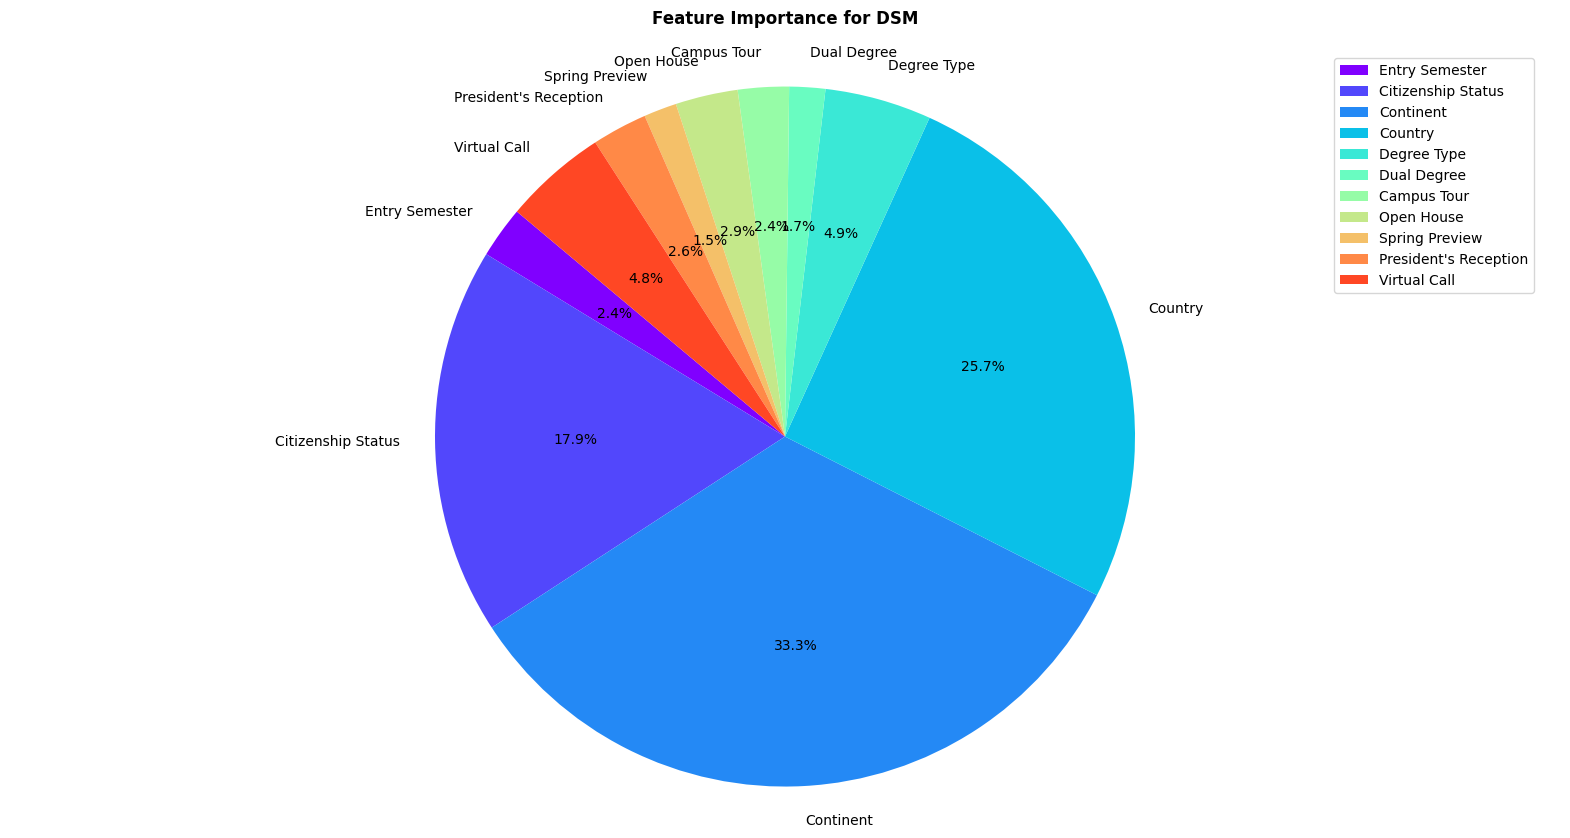

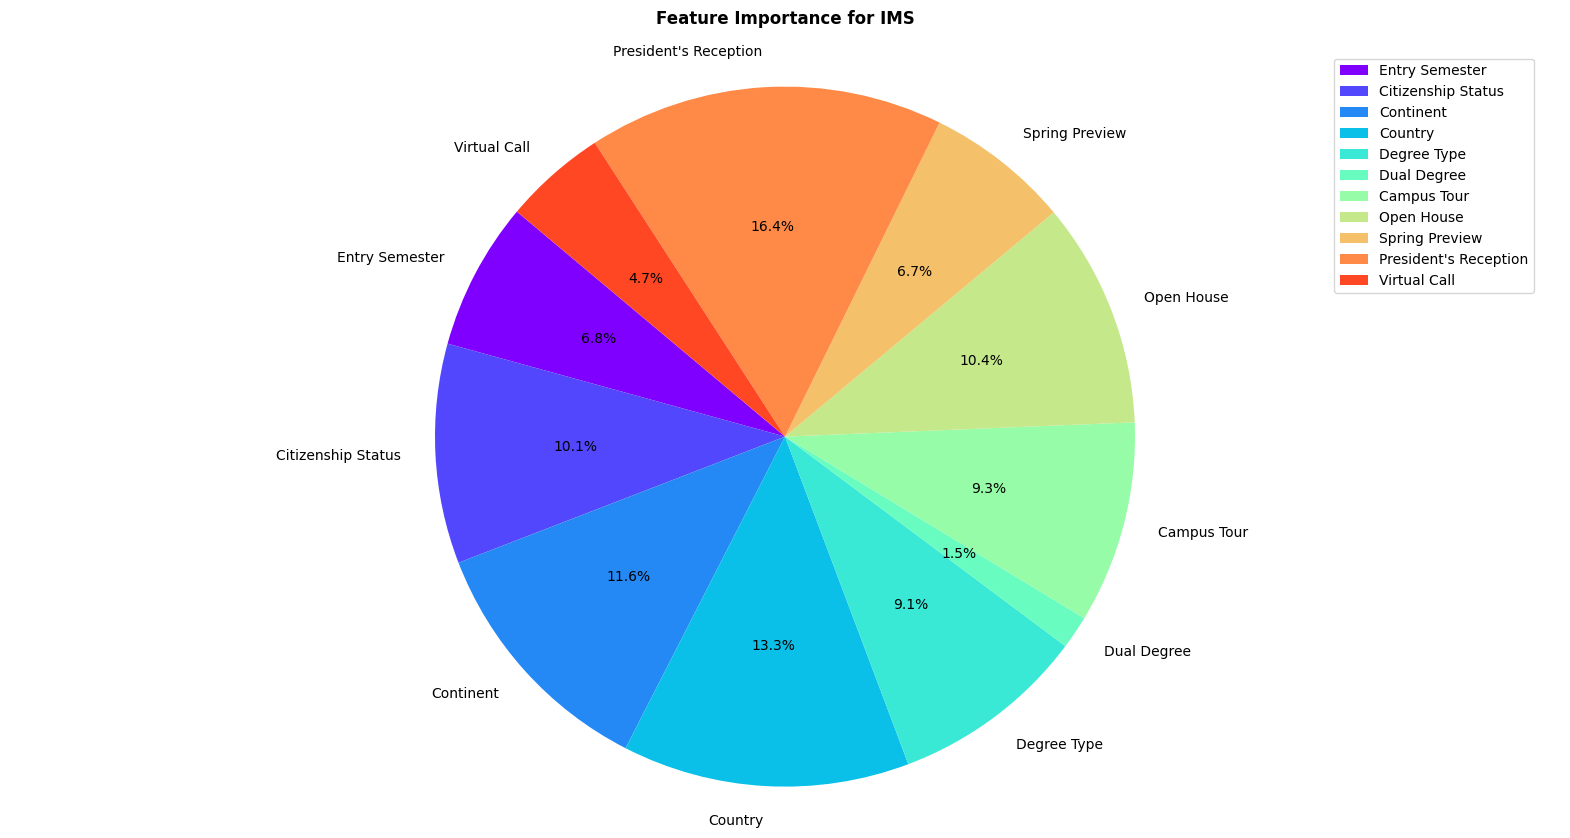

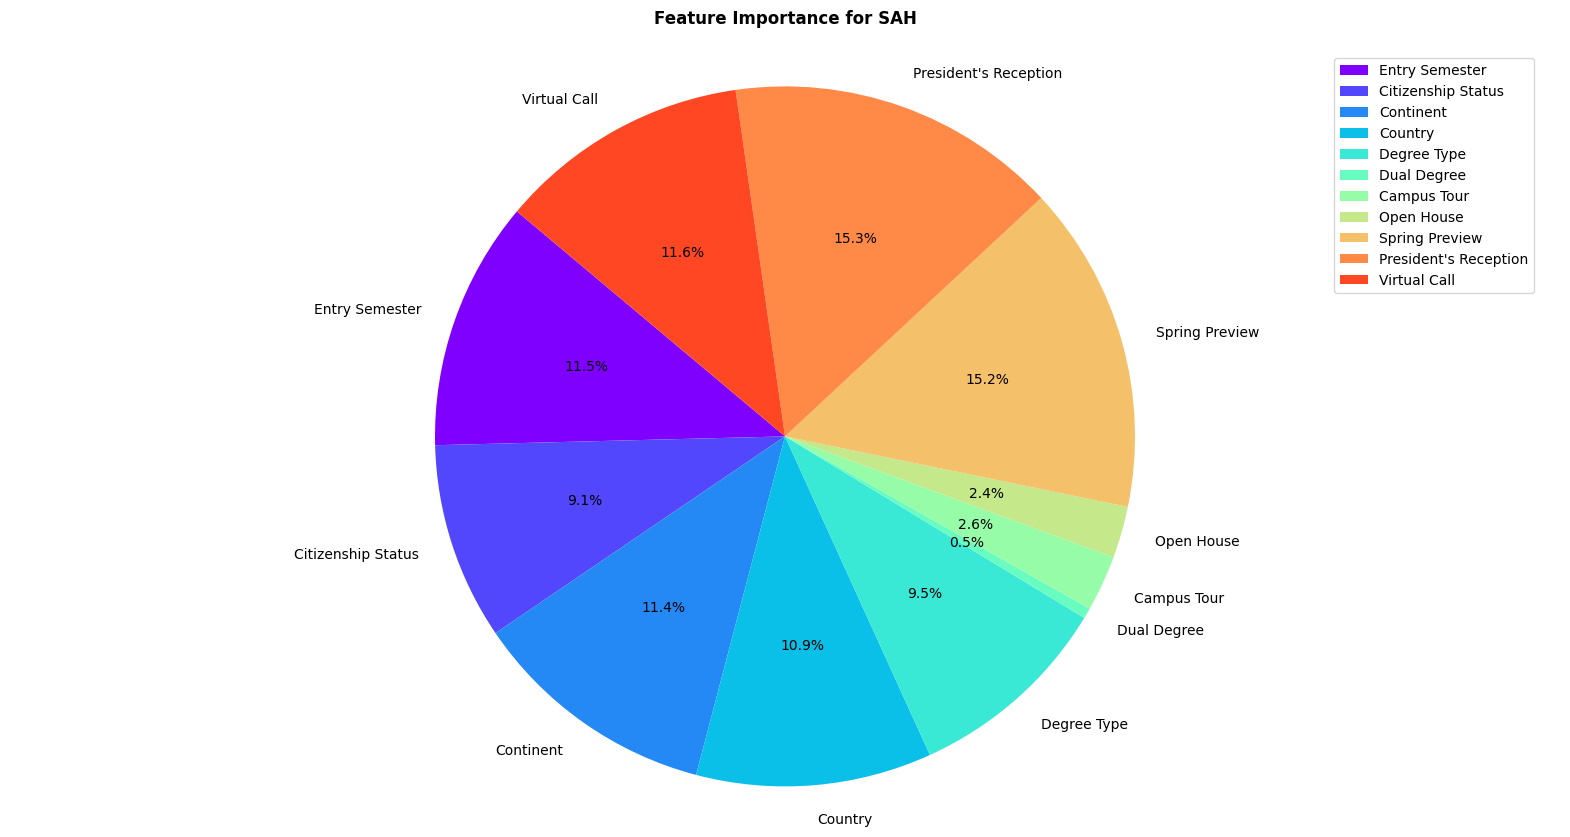

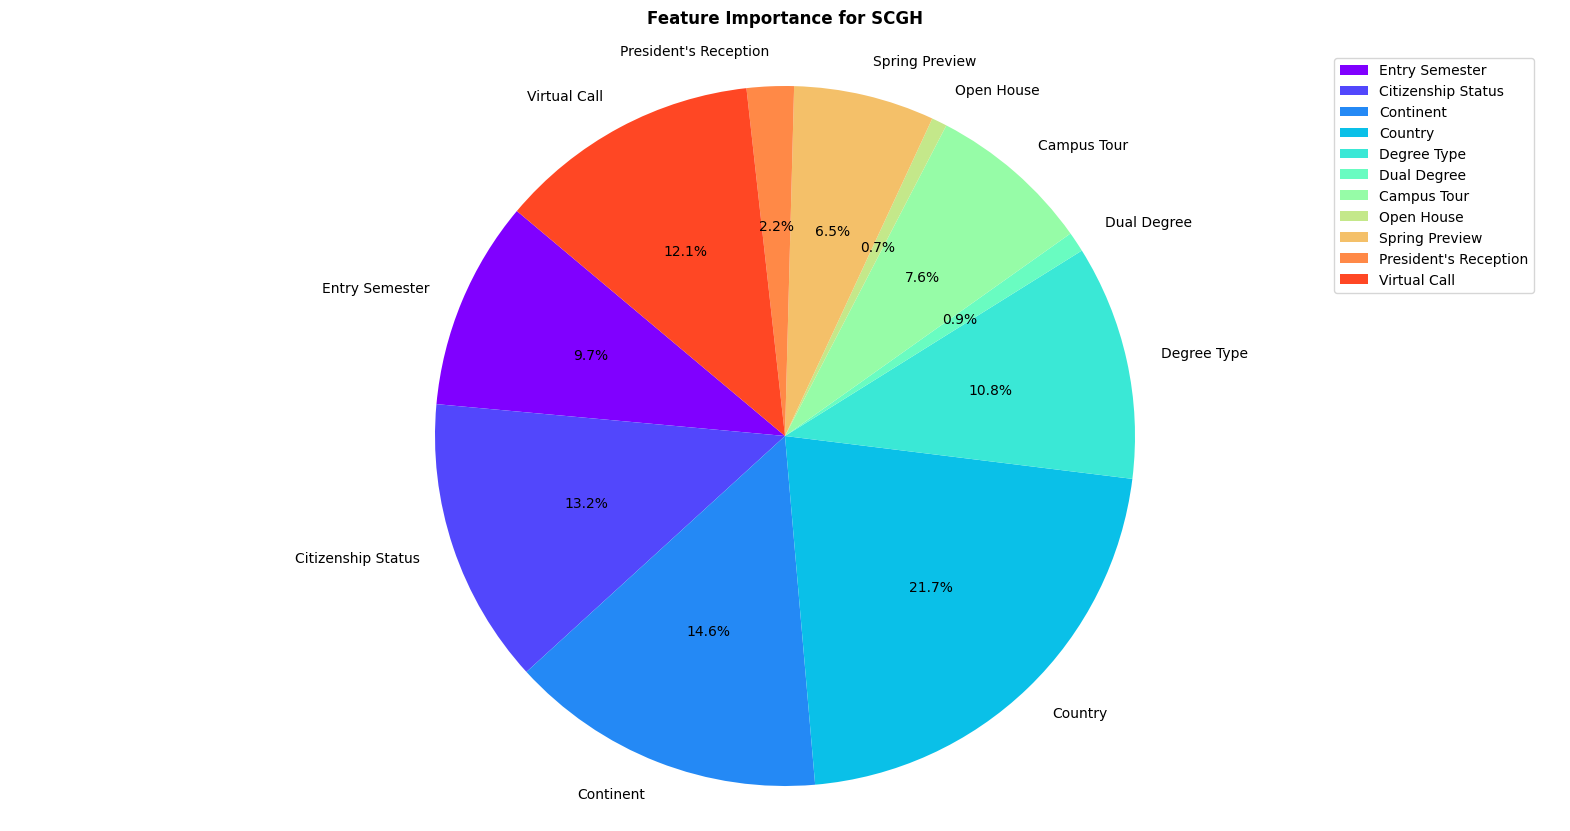

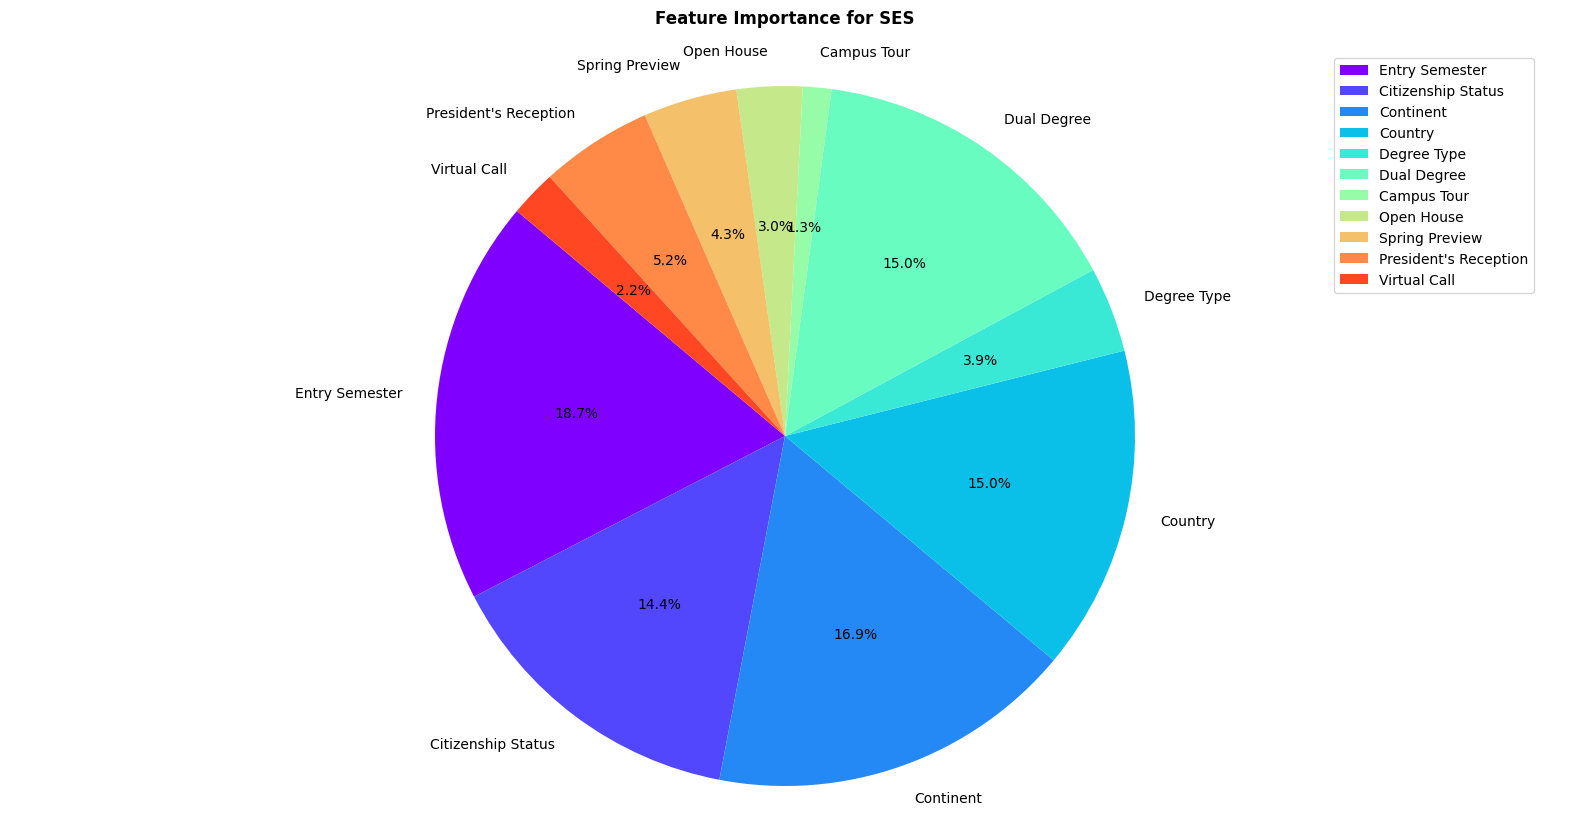

In [41]:
# now do it for all the divisions
for df, division in zip(feature_list, DIVISIONS):
    pie_chart(df, division)

## Download all files

In [43]:
import os
from google.colab import files
import zipfile

# List all files in the current directory
files_to_zip = [f for f in os.listdir('.') if os.path.isfile(f)]

# Create a zip file
with zipfile.ZipFile('project_files.zip', 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file)

# Download the zip file
files.download('project_files.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>